![example](images/director_shot.jpeg)

# Microsoft Movie Recommendations

**Author:** Lia Elwonger
***

## Overview

Microsoft is perhaps best know as a software company, but has many media holding, perhaps most notably in video games via their Xbox consoles and games. How might this company leverage its capital and brand to enter into the film industry?

In this project I analyze data from IMDB and The Numbers to find if there is any association between three variables: genre, director, and release date and the average profit made on a film.

As result of this analysis, I suggest that Microsoft:
* Release an animated film.
* Hire Kyle Balder to direct it. 
* Aim to release the movie in May with July as a backup in case of delays.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
from datetime import date
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 16})

We will be using data from IMDB and The Numbers in our analysis.
Our target variable for all three recommendations will be total profit.
We will look to see if there is any association between the target and three variables:
1. Film Genre
2. Time of Release
3. Director

### Budget, Revenue, and Release Date Data

The data on budgets, revenue and release date will come from the website "The Numbers". It includes data on production budget as well as both domestic and world wide gross revenue, all stored as objects rather than int. There is no data on non-production related expenses such as advertizing budgets, which can also deeply imapct the profitability of a project. The release date data is stored as an object rather than datetime or int.

In [2]:
budgets_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')
budgets_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


This dataset appears to be free from both missing data and duplicate rows.

In [3]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [4]:
budgets_df.value_counts()[:5]

id   release_date  movie                production_budget  domestic_gross  worldwide_gross
100  Sep 2, 2005   The Transporter 2    $32,000,000        $43,095,856     $88,978,458        1
34   Apr 30, 2010  Housefull            $10,100,000        $1,183,658      $18,726,300        1
     Apr 5, 2019   The Best of Enemies  $10,000,000        $10,205,616     $10,205,616        1
     Aug 13, 2010  The Expendables      $82,000,000        $103,068,524    $268,268,174       1
     Aug 25, 2017  Birth of the Dragon  $31,000,000        $6,901,965      $7,220,490         1
dtype: int64

### Genre Data

The data on genres will come from IMDB and includes a column a containing comma seperated listing of the genres that the film has been categorized as, as well as name, runtime and release year.

In [5]:
titles_df = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
titles_df.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


There don't appear to be any duplicate rows, but there is some missing runtime data and genre data

In [6]:
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [7]:
titles_df.value_counts()[:5]

tconst     primary_title                           original_title                          start_year  runtime_minutes  genres                      
tt9916538  Kuambil Lagi Hatiku                     Kuambil Lagi Hatiku                     2019        123.0            Drama                           1
tt2716756  And They Call It Puppy Love             And They Call It Puppy Love             2013        93.0             Crime,Drama,Romance             1
tt2716062  The Giant Spider                        The Giant Spider                        2013        71.0             Horror,Sci-Fi                   1
tt2716194  Tamanna                                 Tamanna                                 2014        83.0             Crime,Drama,Thriller            1
tt2716206  Mrs. Highlander - Von einer die auszog  Mrs. Highlander - Von einer die auszog  2012        54.0             Biography,Documentary,Family    1
dtype: int64

### Director Data

Data for the directors names and films they worked on will come from IMDB as well and is spread over two files. One contains a listing on the role that each person perform on each film, but without their name. The other contains listing of the names of the people in the database along with the roles they typically serve, but without data on what role they play in each film they worked on. These will have to be joined.

In [8]:
principles_df = pd.read_csv('data/zippedData/imdb.title.principals.csv.gz')
principles_df.head(3)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN


In [9]:
names_df = pd.read_csv("data/zippedData/imdb.name.basics.csv.gz") 
names_df.head(3)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"


Both dataset contain missing data, but not in the columns that will be relevant for our analysis.

In [10]:
principles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   tconst      1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   nconst      1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


In [11]:
names_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   nconst              606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
 5   known_for_titles    576444 non-null  object 
dtypes: float64(2), object(4)
memory usage: 27.8+ MB


## Data Preparation

We will begin by joining the dataframes containing the genre information and the budget information and droping some columns that are irrelevant to our analysis.

In [12]:
# Here you run your code to clean the data
budgets_df.set_index('movie', inplace=True)
titles_df.set_index('primary_title', inplace=True)
budget_genre_df = budgets_df.join(titles_df, how='inner')
budget_genre_df.drop(columns = ['original_title', 'runtime_minutes'], inplace=True)
budget_genre_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,start_year,genres
#Horror,16,"Nov 20, 2015","$1,500,000",$0,$0,tt3526286,2015,"Crime,Drama,Horror"
10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422",tt1179933,2016,"Drama,Horror,Mystery"
10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616",tt3453052,2015,Drama
12 Rounds,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648",tt3517850,2017,"Action,Drama,Romance"
12 Strong,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378",tt1413492,2018,"Action,Drama,History"


Above we can see an anomoly caused by joining two datasets that don't have a common key other than their name. 12 Rounds is listed as being released in 2009 in The Numbers data, but in 2017 in the IMDB data, this is because there are two distinct films called "12 Rounds". We will drop any rows with this analomy, and assume that two identically named films are not released in the same year. To do that we will convert the release date into a datetime and then drop any rows where release date and start_year do not align.

In [13]:
budget_genre_df['release_date'] = budget_genre_df['release_date'].map(lambda x: parser.parse(x))
budget_genre_df['the_number_year'] = budget_genre_df['release_date'].dt.year

In [14]:
budget_genre_df = budget_genre_df[budget_genre_df['the_number_year'] == budget_genre_df['start_year']]

In [15]:
budget_genre_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,start_year,genres,the_number_year
#Horror,16,2015-11-20,"$1,500,000",$0,$0,tt3526286,2015,"Crime,Drama,Horror",2015
10 Cloverfield Lane,54,2016-03-11,"$5,000,000","$72,082,999","$108,286,422",tt1179933,2016,"Drama,Horror,Mystery",2016
10 Days in a Madhouse,48,2015-11-11,"$12,000,000","$14,616","$14,616",tt3453052,2015,Drama,2015
12 Strong,64,2018-01-19,"$35,000,000","$45,819,713","$71,118,378",tt1413492,2018,"Action,Drama,History",2018
12 Years a Slave,18,2013-10-18,"$20,000,000","$56,671,993","$181,025,343",tt2024544,2013,"Biography,Drama,History",2013


As mentioned above The data is missing a few rows of genre information. It is a fairly small bit of data, likely from films that are either difficult to categorize or no one bothered to on IMDB. We will just drop them since there is no good way to guess at what genres they may be.

In [16]:
budget_genre_df.dropna(inplace = True)
budget_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, #Horror to xXx: Return of Xander Cage
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1541 non-null   int64         
 1   release_date       1541 non-null   datetime64[ns]
 2   production_budget  1541 non-null   object        
 3   domestic_gross     1541 non-null   object        
 4   worldwide_gross    1541 non-null   object        
 5   tconst             1541 non-null   object        
 6   start_year         1541 non-null   int64         
 7   genres             1541 non-null   object        
 8   the_number_year    1541 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 120.4+ KB


Since microsoft is likely to spend a conisderable amount on a film to make it worth their time, we will filter the data only contain movies with budgets over $10 million.
Since film trends are fairly variable, we will also drop movies that didn't release in the past 20 years.
We will also insert a column that calculates the global profit for each film, which will require turning the objects in the budget and gross columns into integers. We will also turn the date into a datetime object for easier analysis.

In [17]:
def money_to_int(df_column):
    """
    Takes in a pandas df column with strings representing dollar and returns the column in int
    """
    return df_column.map(lambda x: int(x[1:].replace(',','')))

In [18]:
budget_genre_df['production_budget'] = money_to_int(budget_genre_df['production_budget'])
budget_genre_df = budget_genre_df[budget_genre_df['production_budget'] >= 10000000]
budget_genre_df = budget_genre_df[budget_genre_df['start_year'] >= 2001]
budget_genre_df['worldwide_gross'] = money_to_int(budget_genre_df['worldwide_gross'])
budget_genre_df['domestic_gross'] = money_to_int(budget_genre_df['domestic_gross'])
budget_genre_df['profit'] = budget_genre_df.worldwide_gross - budget_genre_df.production_budget
budget_genre_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,start_year,genres,the_number_year,profit
10 Days in a Madhouse,48,2015-11-11,12000000,14616,14616,tt3453052,2015,Drama,2015,-11985384
12 Strong,64,2018-01-19,35000000,45819713,71118378,tt1413492,2018,"Action,Drama,History",2018,36118378
12 Years a Slave,18,2013-10-18,20000000,56671993,181025343,tt2024544,2013,"Biography,Drama,History",2013,161025343
127 Hours,6,2010-11-05,18000000,18335230,60217171,tt1542344,2010,"Adventure,Biography,Drama",2010,42217171
2 Guns,39,2013-08-02,61000000,75612460,132493015,tt1272878,2013,"Action,Comedy,Crime",2013,71493015


We are now in a position to analyze the relationship between both genre and release date with profit, but don't yet have the data on directors. To do so we will join this data base with the other two, group it by director and calculate the mean profit that each director has made. 

In [19]:
principles_df = principles_df.drop(columns = ['job','characters'])
names_df = names_df.drop(columns = ['birth_year', 'death_year', 'known_for_titles']).dropna()
principles_df.set_index('nconst', inplace=True)
names_df.set_index('nconst', inplace=True)
name_profession_df = principles_df.join(names_df, how='inner')
name_profession_df = name_profession_df[name_profession_df["category"].str.contains('director')==True]
name_profession_df.head()

,tconst,ordering,category,primary_name,primary_profession
nconst,,,,,
nm0000080,tt0069049,5,director,Orson Welles,"actor,director,writer"
nm0000095,tt1605783,5,director,Woody Allen,"writer,director,actor"
nm0000095,tt1182350,5,director,Woody Allen,"writer,director,actor"
nm0000095,tt2334873,5,director,Woody Allen,"writer,director,actor"
nm0000095,tt2870756,5,director,Woody Allen,"writer,director,actor"


We will now join it with the budget and genre table.

In [20]:
budget_genre_df.set_index('tconst', inplace=True)
name_profession_df.reset_index(inplace = True)
name_profession_df.set_index('tconst', inplace=True)
complete_df = name_profession_df.join(budget_genre_df, how='inner')
complete_df = complete_df.drop(columns = ['ordering','primary_profession', 'id', 'start_year', 'the_number_year'])
complete_df.head(3)

,nconst,category,primary_name,release_date,production_budget,domestic_gross,worldwide_gross,genres,profit
tconst,,,,,,,,,
tt0249516,nm0440415,director,Lawrence Kasanoff,2012-12-31,45000000,0,73706,"Action,Animation,Comedy",-44926294
tt0365907,nm0291082,director,Scott Frank,2014-09-19,28000000,26017685,62108587,"Action,Crime,Drama",34108587
tt0369610,nm1119880,director,Colin Trevorrow,2015-06-12,215000000,652270625,1648854864,"Action,Adventure,Sci-Fi",1433854864


We now have a dataframe connecting the directors to the profit they made on their movies.

## Data Modeling

### Genre Analysis

We will begin analyzing the genre data by constructing a table which give us the mean profit for each genre as well as the std deviation. This will give us a reasonable representation of the expected profit from each genre and a rough measure of the risk.

In [21]:
# Constructing a list of all the genres in the database
genre_list = []
for entry in list(budget_genre_df['genres'].dropna()):
    genres = entry.split(',')
    for genre in genres:
        if genre not in genre_list:
            genre_list.append(genre)

In [22]:
def genre_filter(df, genre):
    """
    Takes a pd dataframe and filters the dataframe to only contain those movies of the specified genre
    """
    return df[df["genres"].str.contains(genre)==True]


In [23]:
def mean_genre_profit_table(df, genres):
    """
    Takes a dataframe and a list of all the genres in the df and returns a df with the mean and std
    of the profit in millions for each genre
    """
    m_s_dict = {}
    for genre in genres:
        profit_df = genre_filter(budget_genre_df, genre)["profit"]
        data_mean = profit_df.mean()/1000000
        data_std = profit_df.std()/1000000
        m_s_dict[genre] = [data_mean, data_std]
    output_df = pd.DataFrame.from_dict(m_s_dict)
    output_df.index = ['mean', 'std']
    output_df = output_df.transpose().sort_values('mean')
    return output_df   

In [24]:
# Constructing a table with the mean and std of the profit of the movies
genre_stats_df = mean_genre_profit_table(budget_genre_df, genre_list)
genre_stats_df.head()

,mean,std
War,35.183110,76.052106
Sport,35.568845,48.204104
History,52.593769,88.617067
Crime,59.323685,139.247642
Drama,61.611379,114.143826


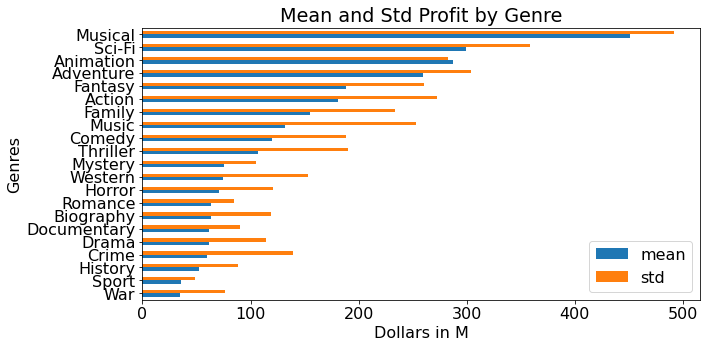

In [25]:
# Plotting the table
genre_stats_df.sort_values(by = 'mean', inplace = True)
genre_stats_plot = genre_stats_df.plot.barh()
genre_stats_plot.set(xlabel= "Dollars in M", ylabel="Genres", title="Mean and Std Profit by Genre");

Musicals have been one of the more sucessful genres in the past 20 year, but have been fairly risky with fairly high variance in the profit they earn. Animation offers a good tradeoff between expect profit and risk, as it has the third best mean profit and is the only category where the std is less that the mean profit, meaning losses are fairly rare. Additionally, if we check the data, (see below) there are only 5 musicals in the dataset. This is a rather small sample to draw big conclusions from, and the data on animation is much more robust.

In [26]:
genre_count = dict.fromkeys(genre_list, 0)
for entry in list(budget_genre_df['genres'].dropna()):
    genres = entry.split(',')
    for genre in genres:
        genre_count[genre] += 1
genre_count

{'Drama': 503,
 'Action': 394,
 'History': 37,
 'Biography': 108,
 'Adventure': 329,
 'Comedy': 393,
 'Crime': 189,
 'Thriller': 182,
 'Fantasy': 104,
 'War': 14,
 'Sport': 26,
 'Romance': 125,
 'Horror': 94,
 'Sci-Fi': 111,
 'Family': 76,
 'Mystery': 80,
 'Musical': 5,
 'Music': 34,
 'Animation': 98,
 'Documentary': 18,
 'Western': 7}

There are also background reasons for favoring the animation genre. The genre likely synergizes more easily with microsofts expertise since the company has animator involved in it gaming projects. Animated movies are also easier to tie into video game like content, which also cross promotion opportunities. Finally animated works often allow for addition profits to be earned from mechantise and toys.

### Release Date Analysis

To determine what release month is best we will construct a bar chart of the mean profit by month.

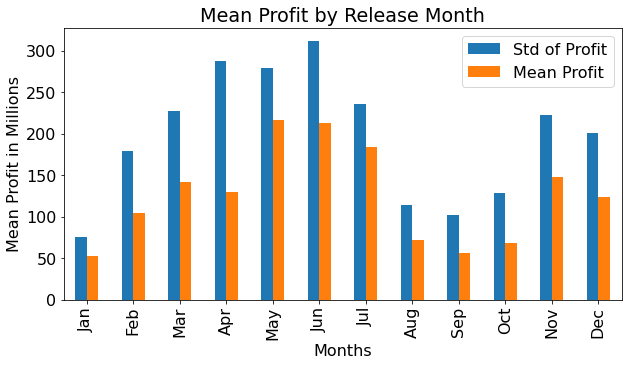

In [27]:
release_df = pd.DataFrame()
release_df['release_month'] = budget_genre_df['release_date'].map(lambda x: x.month)
release_df['profit'] = budget_genre_df['profit'].map(lambda x: x/1000000)
release_df.reset_index(inplace = True)
release_df.drop(columns = ['tconst'])
mean_df = release_df.groupby(by = 'release_month').mean()
release_df = release_df.groupby(by = 'release_month').std()
release_df.rename(columns = {'profit' : 'Std of Profit'}, inplace=True)
release_df['Mean Profit'] = mean_df['profit']
release_plot = release_df.plot.bar()
release_plot.set(xlabel= "Months", ylabel="Mean Profit in Millions", title="Mean Profit by Release Month")
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
release_plot.set_xticklabels(xlabels);

It appears that May has the highest mean profit, but July is almost as good with less variance. Any summer release appears reasonable from this data. Shotting for a May release with a buffer for a potential July release in case of delays may be a good strategy. This also fits with likely information about the attendence of the demographic likely to consume animation, since children have more free time during the summer.

### Director Analysis

To determine what director would be reasonable we will filter the database to only include animated movies and then group the database by director and sort them by the mean profit from their films to find the top 10 candidates.

In [28]:
animated_direct_df = complete_df[complete_df['genres'].str.contains('Animation')==True]
animated_direct_df = animated_direct_df.drop(columns = ['worldwide_gross', 'domestic_gross', 'production_budget'])
animated_direct_df = animated_direct_df.groupby(by='primary_name').mean()
animated_direct_df.sort_values(by='profit', ascending = False, inplace = True)
animated_direct_df.rename(columns = {'profit': 'Mean Profit'}, inplace = True)
animated_direct_df.head(10)

,Mean Profit
primary_name,
Chris Buck,1.122470e+09
Jennifer Lee,1.122470e+09
Brad Bird,1.042521e+09
Kyle Balda,1.023032e+09
Eric Guillon,9.597278e+08
Jared Bush,8.694296e+08
Andrew Stanton,8.212152e+08
Angus MacLane,8.212152e+08
Yarrow Cheney,8.117505e+08


We will also look at the rankings by total profit, since some directors may have a high mean simply from having only directed one very successful film.

In [29]:
total_direct_df = complete_df[complete_df['genres'].str.contains('Animation')==True]
total_direct_df = total_direct_df.drop(columns = ['worldwide_gross', 'domestic_gross', 'production_budget'])
animated_direct_df['Total Profit'] = total_direct_df.groupby(by='primary_name').sum()
animated_direct_df.sort_values(by='Total Profit', ascending = False, inplace = True)
animated_direct_df.head(10)

,Mean Profit,Total Profit
primary_name,,
Pierre Coffin,7.778031e+08,2333409158
Chris Renaud,5.546959e+08,2218783438
Kyle Balda,1.023032e+09,2046063923
Lee Unkrich,7.459438e+08,1491887623
Mike Mitchell,3.291241e+08,1316496511
Rich Moore,6.004706e+08,1200941137
Byron Howard,5.979534e+08,1195906856
Dean DeBlois,3.965718e+08,1189715545
Tom McGrath,3.932291e+08,1179687241


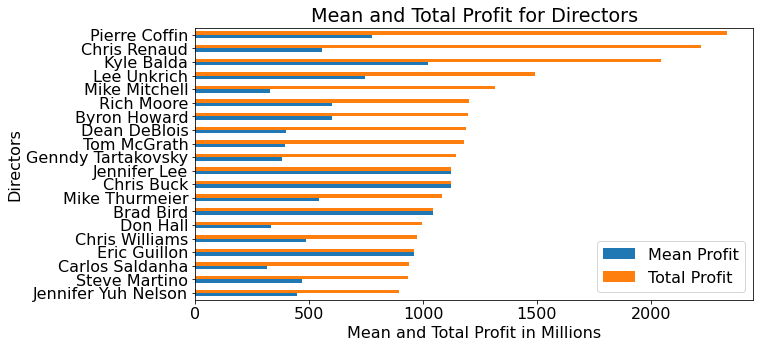

In [30]:
animated_direct_df['Mean Profit'] = animated_direct_df['Mean Profit'].map(lambda x: x/1000000)
animated_direct_df['Total Profit'] = animated_direct_df['Total Profit'].map(lambda x: x/1000000)
animated_direct_df.sort_values(by='Total Profit', ascending = True, inplace = True)
animated_direct_plot = animated_direct_df.tail(20).plot.barh()
animated_direct_plot.set(ylabel= "Directors", xlabel="Mean and Total Profit in Millions", title="Mean and Total Profit for Directors");

Based on this analysis Kyle Balda offers a good balance of high average return with more of a track record of success.

## Evaluation

Any analysis done with only this data will be inherently limited. 

To begin with, the data only contains information about production budgets and not other expenses. For instance, if animated films are adversized much more than other film, then that would cut into the profit that this analysis suggest they have.

There are also problems with inferring causal claims from this data. For example, if Hollywood expects that summer is more profitable, they will likely release their big tent poll films during that time, which will then also skew the data into suggeesting the summer is profitable. With jsut his data, it is difficult to tell.

There are also numerous problems with making inferences from small samples, for example, many of the most profitable directors only made a couple of film, wildly successful ones such as Frozen and the Despicables franchise, but it is not clear this will be very predictive of their success in new or different projects.

## Conclusions

My stated recommendations:

* Release an animated film.
* Hire Kyle Balder to direct it. 
* Aim to release the movie in May with July as a backup in case of delays.

### Caveats and Future Work

This leaves many other issues unresolved. What script sould the movie use and should it be connected to other Microsoft media projects, which has potential rewards in increased sales in other areas such as video games, but also risks in damging the brand if the movie fails.

I suggest that Microsoft:
* Do market research into what story types and themes are popular.
* Investigate whether it has existing media brands that would fit well with an animated film.
* Do toy and mechandise marketing research to determine what media is likely to earn additional profit from those.